# Autoregressive contrastive coder

In [1]:
import patches
import lettertask as lt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import plotnine as gg
import lazytools_sflippl as lazytools
import numpy as np

## Dataset

In [2]:
obm = lt.data.OccludedBinaryModel(occlusion_probability=0.1, occlusion_remainder_probability=0.5, occlusion_range=0.2, presamples=10000)

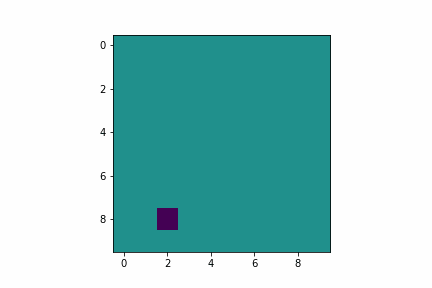

In [3]:
obm.animate(n=50)

## Clamp

In [4]:
def model_generator(input_features, latent_features, timesteps=0, **kwargs):
    encoder = nn.Linear(input_features, latent_features)
    predictor = nn.Linear(latent_features, 5*latent_features)
    decoder = nn.Linear(5*latent_features, 5*input_features)
    return {
        'encoder': encoder,
        'predictor': predictor,
        'decoder': decoder
    }

In [5]:
clamp = patches.patchclamp.PatchClamp(model_generator)

In [6]:
scr = clamp.get_scr(100, 1)

## Supervised model

In [7]:
loss_traj = []

In [8]:
latent_array = obm.values.reshape(1, *obm.values.shape)
dataset = scr.dataset(obm.to_array().reshape(1, *obm.to_array().shape),
                        latent_array, timesteps=5)

In [9]:
epochs = 10
optimizer = optim.Adam(scr.parameters(), lr=0.001)
with tqdm(total=len(dataset)*epochs) as pbar:
    for epoch in range(epochs):
        running_loss = 0
        for i, data in enumerate(dataset):
            optimizer.zero_grad()
            model_output = scr(data)
            loss = scr.loss(model_output, data,
                            input_loss=nn.MSELoss(),
                            latent_loss=nn.MSELoss())
            loss.backward()
            optimizer.step()
            running_loss += loss
            if i % 50 == 49:
                loss_traj.append(running_loss.detach().numpy()/50)
                running_loss = 0
            pbar.update(1)

100%|██████████| 12490/12490 [00:13<00:00, 918.56it/s] 


In [10]:
list(scr.parameters())

[Parameter containing:
 tensor([[0.7371, 0.7680, 0.6397, 0.7735, 0.7674, 0.7557, 0.8572, 0.7198, 0.8598,
          0.8723, 0.8642, 0.8109, 0.7965, 0.7639, 0.7856, 0.7787, 0.8190, 0.8424,
          0.8157, 0.7240, 0.8655, 0.7847, 0.7177, 0.8397, 0.8214, 0.7597, 0.8667,
          0.8669, 0.6019, 0.6339, 0.8600, 0.7969, 0.8024, 0.7093, 0.7123, 0.8297,
          0.7348, 0.7423, 0.9001, 0.8204, 0.7726, 0.7436, 0.7710, 0.7128, 0.7896,
          0.8569, 0.7743, 0.8058, 0.7856, 0.7738, 0.7146, 0.8434, 0.8143, 0.8853,
          0.7744, 0.6930, 0.8202, 0.8127, 0.8652, 0.7195, 0.8353, 0.7732, 0.8584,
          0.8389, 0.7579, 0.7467, 0.7092, 0.6831, 0.7593, 0.7410, 0.6451, 0.8250,
          0.8800, 0.7430, 0.8163, 0.8168, 0.7909, 0.7548, 0.8740, 0.7703, 0.7842,
          0.8735, 0.7545, 0.7720, 0.7812, 0.7856, 0.7834, 0.7314, 0.6947, 0.7947,
          0.8386, 0.8116, 0.6678, 0.8853, 0.7996, 0.8290, 0.6905, 0.8452, 0.7810,
          0.7758]], requires_grad=True), Parameter containing:
 tensor([-0.

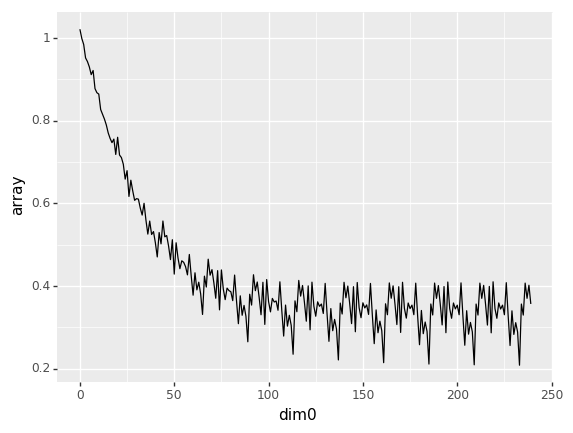

<ggplot: (8776617118668)>

In [11]:
(gg.ggplot(lazytools.array_to_dataframe(np.array(loss_traj)), gg.aes(x='dim0', y='array')) +
    gg.geom_line())

In [12]:
model_output

tensor([[[-0.7884]],

        [[-0.7944]],

        [[-0.7669]],

        [[-0.8890]],

        [[-0.8491]],

        [[-0.8900]],

        [[-0.1582]],

        [[ 0.2225]]], grad_fn=<AddBackward0>)

We see that it works, but is complicated by the noisy data.

## Supervised prediction

In [13]:
spcr = clamp.get_spcr(100, 1, timesteps=5)

In [14]:
latent_array = obm.values.reshape(1, *obm.values.shape)
dataset = spcr.dataset(obm.to_array().reshape(1, *obm.to_array().shape),
                        latent_array, timesteps=5)

In [15]:
spcr

ClampedModel(
  (_module): Predictor(
    (encoder): Linear(in_features=100, out_features=1, bias=True)
    (predictor): Linear(in_features=1, out_features=5, bias=True)
  )
)

In [16]:
epochs = 10
optimizer = optim.Adam(spcr.parameters(), lr=0.001)
with tqdm(total=len(dataset)*epochs) as pbar:
    for epoch in range(epochs):
        running_loss = 0
        for i, data in enumerate(dataset):
            optimizer.zero_grad()
            model_output = spcr(data)
            loss = spcr.loss(model_output, data,
                            input_loss=nn.MSELoss(),
                            latent_loss=nn.MSELoss())
            loss.backward()
            optimizer.step()
            running_loss += loss
            if i % 50 == 49:
                loss_traj.append(running_loss.detach().numpy()/50)
                running_loss = 0
            pbar.update(1)

100%|██████████| 12490/12490 [00:20<00:00, 615.36it/s]


In [17]:
list(spcr.parameters())

[Parameter containing:
 tensor([[-0.5187, -0.5666, -0.4029, -0.4622, -0.6076, -0.5624, -0.6340, -0.5243,
          -0.5599, -0.5414, -0.6108, -0.5649, -0.5221, -0.5407, -0.5693, -0.4644,
          -0.6105, -0.5133, -0.6152, -0.5250, -0.5592, -0.5182, -0.4536, -0.6112,
          -0.5487, -0.4728, -0.6301, -0.6779, -0.4598, -0.4422, -0.6079, -0.4873,
          -0.4936, -0.4439, -0.5990, -0.5300, -0.4496, -0.4640, -0.6423, -0.5684,
          -0.5194, -0.5709, -0.5173, -0.4229, -0.5575, -0.5882, -0.5356, -0.5737,
          -0.5802, -0.5292, -0.2459, -0.6084, -0.4983, -0.6547, -0.5416, -0.4090,
          -0.5171, -0.5036, -0.6039, -0.5225, -0.5523, -0.5143, -0.6145, -0.5553,
          -0.4546, -0.5603, -0.4349, -0.4762, -0.5500, -0.4687, -0.4148, -0.5827,
          -0.5301, -0.5454, -0.5813, -0.6115, -0.5687, -0.4712, -0.6179, -0.5932,
          -0.4865, -0.5866, -0.5665, -0.5126, -0.4938, -0.4667, -0.4983, -0.5887,
          -0.3852, -0.5267, -0.5177, -0.5283, -0.4398, -0.5923, -0.5600, -0

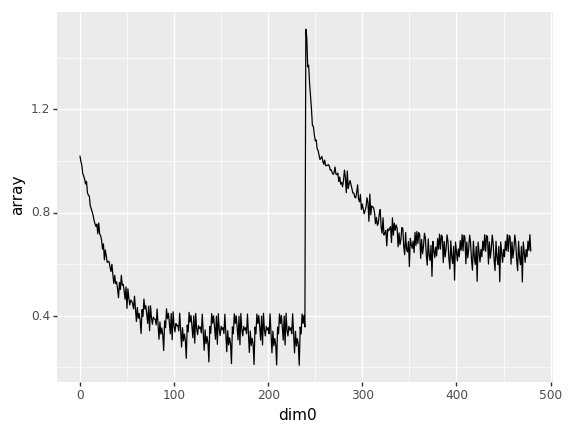

<ggplot: (-9223363260237647160)>

In [18]:
(gg.ggplot(lazytools.array_to_dataframe(np.array(loss_traj)), gg.aes(x='dim0', y='array')) +
    gg.geom_line())

## Contrastive coding

In [38]:
cc = clamp.get_cc(input_features=100, latent_features=1, timesteps=5, contrast_size=49)

In [39]:
latent_array = obm.values.reshape(1, *obm.values.shape)
dataset = cc.dataset(obm.to_array().reshape(1, *obm.to_array().shape),
                        latent_array, timesteps=5)

In [40]:
loss_traj = []
epochs = 10
optimizer = optim.Adam(cc.parameters(), lr=0.001)
with tqdm(total=len(dataset)*epochs) as pbar:
    for epoch in range(epochs):
        running_loss = 0
        for i in range(len(dataset)):
            data = dataset[i]
            optimizer.zero_grad()
            model_output = cc(data)
            loss = cc.loss(model_output, data,
                            input_loss=nn.MSELoss(),
                            latent_loss=patches.losses.BilinearLoss())
            loss.backward()
            optimizer.step()
            running_loss += loss
            if i % 50 == 49:
                loss_traj.append(running_loss.detach().numpy()/50)
                running_loss = 0
            pbar.update(1)

100%|██████████| 99950/99950 [02:40<00:00, 623.28it/s]


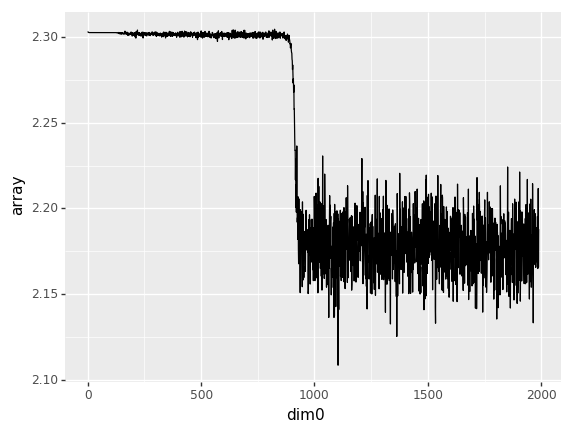

<ggplot: (-9223363260233494286)>

In [41]:
(gg.ggplot(lazytools.array_to_dataframe(np.array(loss_traj)), gg.aes(x='dim0', y='array')) +
    gg.geom_line())

In [31]:
data.shape

torch.Size([10, 6, 100])

In [42]:
list(cc.parameters())

[Parameter containing:
 tensor([[0.4940, 0.5116, 0.4635, 0.5770, 0.6580, 0.5335, 0.6248, 0.6058, 0.6235,
          0.6098, 0.5995, 0.6091, 0.5424, 0.5569, 0.6021, 0.4868, 0.6533, 0.6447,
          0.5995, 0.5360, 0.6585, 0.5030, 0.4888, 0.5667, 0.5643, 0.5098, 0.5396,
          0.6677, 0.4565, 0.5250, 0.6111, 0.4677, 0.5240, 0.4126, 0.5488, 0.5376,
          0.6219, 0.5951, 0.7115, 0.5768, 0.5999, 0.5913, 0.4733, 0.4359, 0.5664,
          0.6325, 0.5431, 0.6435, 0.4816, 0.5992, 0.3852, 0.6056, 0.5754, 0.6413,
          0.5233, 0.4738, 0.5279, 0.5819, 0.6085, 0.5370, 0.6434, 0.5441, 0.6282,
          0.6406, 0.4829, 0.6123, 0.5167, 0.4516, 0.5810, 0.5698, 0.5048, 0.6414,
          0.5863, 0.5716, 0.5493, 0.5646, 0.6605, 0.4726, 0.5711, 0.5553, 0.6046,
          0.6773, 0.6056, 0.6157, 0.5185, 0.5878, 0.6442, 0.5203, 0.4412, 0.5370,
          0.5427, 0.5583, 0.5225, 0.5809, 0.4832, 0.5314, 0.4782, 0.6218, 0.5967,
          0.5276]], requires_grad=True), Parameter containing:
 tensor([0.1

We see that this works for the normal contrastive coder! The approach below will be to investigate whether adding an autoregressive component will improve performance. For this purpose, we will first try to break the conventional contrastive coder.

## Breaking CC

In [59]:
loss_trajs = []
angles = []

In [60]:
for orp in [0.75, 0.9, 0.95]:
    obm = lt.data.OccludedBinaryModel(occlusion_probability=0.1, occlusion_remainder_probability=orp, occlusion_range=0.2, presamples=10000)
    tmp_cc = clamp.get_cc(input_features=100, latent_features=1, timesteps=5, contrast_size=49)
    latent_array = obm.values.reshape(1, *obm.values.shape)
    dataset = cc.dataset(obm.to_array().reshape(1, *obm.to_array().shape),
                         latent_array, timesteps=5)
    loss_traj = []
    angle = []
    epochs = 10
    optimizer = optim.Adam(tmp_cc.parameters(), lr=0.01)
    with tqdm(total=len(dataset)*epochs) as pbar:
        for epoch in range(epochs):
            running_loss = 0
            for i in range(len(dataset)):
                data = dataset[i]
                optimizer.zero_grad()
                model_output = tmp_cc(data)
                loss = tmp_cc.loss(model_output, data,
                                input_loss=nn.MSELoss(),
                                latent_loss=patches.losses.BilinearLoss())
                loss.backward()
                optimizer.step()
                running_loss += loss
                if i % 50 == 49:
                    loss_traj.append(running_loss.detach().numpy()/50)
                    coder = next(tmp_cc.parameters()).detach().numpy().flatten()
                    angle.append(coder.sum()/np.sqrt((coder**2).sum()))
                    running_loss = 0
                pbar.update(1)
    loss_trajs.append(loss_traj)
    angles.append(angle)

100%|██████████| 99950/99950 [02:36<00:00, 638.21it/s]


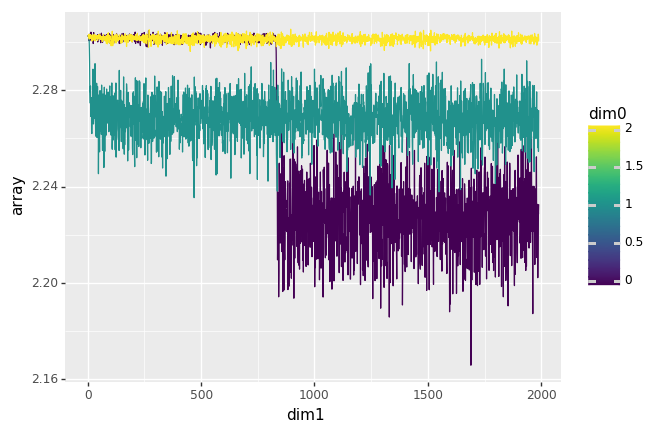

<ggplot: (-9223363260248308003)>

In [63]:
(gg.ggplot(lazytools.array_to_dataframe(np.array(loss_trajs)), gg.aes(x='dim1', color='dim0', y='array', group='dim0')) +
    gg.geom_line())

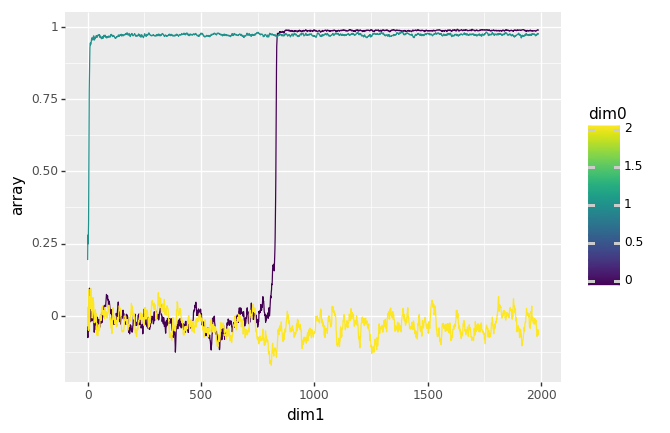

<ggplot: (8776621329479)>

In [74]:
(gg.ggplot(lazytools.array_to_dataframe(np.array(angles)/10), gg.aes(x='dim1', color='dim0', y='array', group='dim0')) +
    gg.geom_line())

We break the scenario where the occlusion parameter remains with a probability of 0.95:

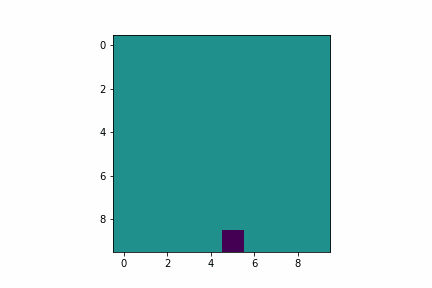

In [64]:
obm.animate(n=100)

It is quite interesting that the middle tier converges way faster.

The next section will develop the code for the autoregressive contrastive coder.

First of all, though, we ask if this can be recovered by less complexity (somewhat equivalent to more samples, but less costly).

In [66]:
obm = lt.data.OccludedBinaryModel(width=10, occlusion_probability=0.1, occlusion_remainder_probability=orp, occlusion_range=0.2, presamples=10000)

In [71]:
cc = clamp.get_cc(input_features=10, latent_features=1, timesteps=5, contrast_size=49)
latent_array = obm.values.reshape(1, *obm.values.shape)
dataset = cc.dataset(obm.to_array().reshape(1, *obm.to_array().shape),
                     latent_array, timesteps=5)
loss_traj = []
angle = []
epochs = 10
optimizer = optim.Adam(cc.parameters(), lr=0.01)
with tqdm(total=len(dataset)*epochs) as pbar:
    for epoch in range(epochs):
        running_loss = 0
        for i in range(len(dataset)):
            data = dataset[i]
            optimizer.zero_grad()
            model_output = cc(data)
            loss = cc.loss(model_output, data,
                            input_loss=nn.MSELoss(),
                            latent_loss=patches.losses.BilinearLoss())
            loss.backward()
            optimizer.step()
            running_loss += loss
            if i % 50 == 49:
                loss_traj.append(running_loss.detach().numpy()/50)
                coder = next(cc.parameters()).detach().numpy().flatten()
                angle.append(coder.sum()/np.sqrt((coder**2).sum()))
                running_loss = 0
            pbar.update(1)

100%|██████████| 99950/99950 [02:44<00:00, 606.77it/s]


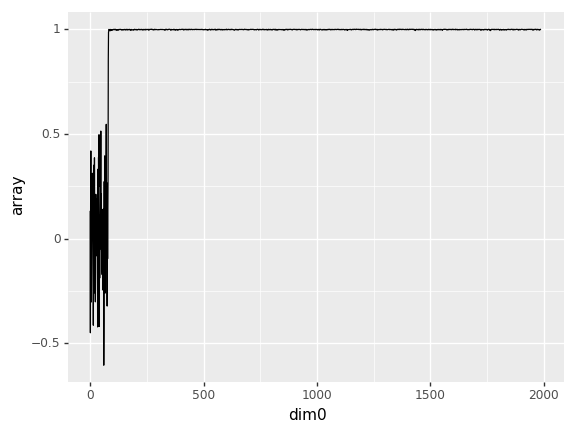

<ggplot: (8776621267990)>

In [73]:
(gg.ggplot(lazytools.array_to_dataframe(np.array(angle/np.sqrt(10))), gg.aes(x='dim0', y='array')) +
    gg.geom_line())

Let's now study reconstructive algorithms.

## UPA settings

In [35]:
obm = lt.data.OccludedBinaryModel(occlusion_probability=0.1, occlusion_remainder_probability=0.5, occlusion_range=0.2, presamples=10000)

In [36]:
upa = clamp.get_upa(input_features=100, latent_features=1, timesteps=5)

In [37]:
latent_array = obm.values.reshape(1, *obm.values.shape)
dataset = upa.dataset(obm.to_array().reshape(1, *obm.to_array().shape),
                        latent_array, timesteps=5)

In [38]:
epochs = 100
optimizer = optim.Adam(upa.parameters(), lr=0.001)
loss_traj = []
angle = []
with tqdm(total=len(dataset)*epochs) as pbar:
    for epoch in range(epochs):
        running_loss = 0
        for i, data in enumerate(dataset):
            optimizer.zero_grad()
            model_output = upa(data)
            loss = upa.loss(model_output, data,
                            input_loss=nn.MSELoss(),
                            latent_loss=nn.MSELoss())
            loss.backward()
            optimizer.step()
            running_loss += loss
            if i % 50 == 49:
                loss_traj.append(running_loss.detach().numpy()/50)
                coder = next(upa.parameters()).detach().numpy()
                angle.append(coder.sum()/(np.sqrt((coder**2).sum())*10))
                running_loss = 0
            pbar.update(1)

100%|██████████| 124900/124900 [02:42<00:00, 769.19it/s]


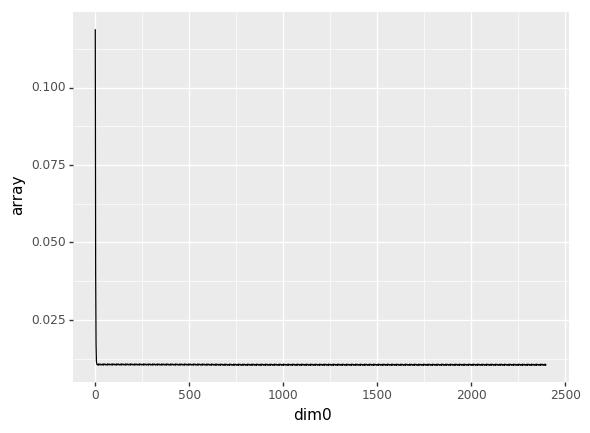

<ggplot: (-9223363242743680638)>

In [39]:
(gg.ggplot(lazytools.array_to_dataframe(np.array(loss_traj)), gg.aes(x='dim0', y='array')) +
    gg.geom_line())

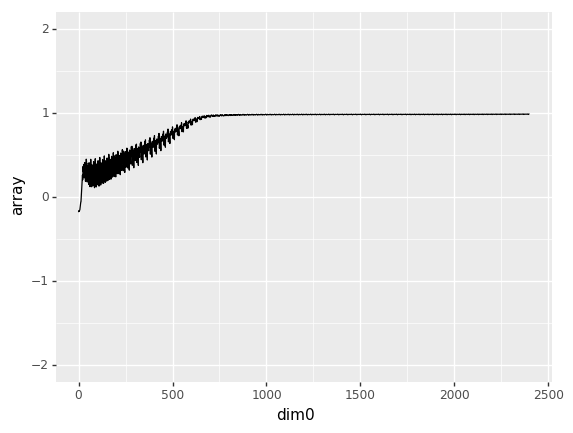

<ggplot: (8794111058650)>

In [40]:
(gg.ggplot(lazytools.array_to_dataframe(np.array(angle)), gg.aes(x='dim0', y='array')) +
    gg.geom_line() + 
    gg.ylim([-2, 2]))

Reconstruction also works! We now move this into a more challenging territory, as well.

In [51]:
loss_trajs = []
angles = []
for orp in [0.75, 0.9, 0.95]:
    obm = lt.data.OccludedBinaryModel(occlusion_probability=0.1, occlusion_remainder_probability=orp, occlusion_range=0.2, presamples=10000)
    tmp_upa = clamp.get_upa(input_features=100, latent_features=1, timesteps=5)
    latent_array = obm.values.reshape(1, *obm.values.shape)
    dataset = tmp_upa.dataset(obm.to_array().reshape(1, *obm.to_array().shape),
                         latent_array, timesteps=5)
    loss_traj = []
    angle = []
    epochs = 50
    optimizer = optim.Adam(tmp_upa.parameters(), lr=0.01)
    with tqdm(total=len(dataset)*epochs) as pbar:
        for epoch in range(epochs):
            running_loss = 0
            for i, data in enumerate(dataset):
                optimizer.zero_grad()
                model_output = tmp_upa(data)
                loss = tmp_upa.loss(model_output, data,
                                input_loss=nn.MSELoss(),
                                latent_loss=patches.losses.BilinearLoss())
                loss.backward()
                optimizer.step()
                running_loss += loss
                if i % 50 == 49:
                    loss_traj.append(running_loss.detach().numpy()/50)
                    coder = next(tmp_upa.parameters()).detach().numpy().flatten()
                    angle.append(coder.sum()/np.sqrt((coder**2).sum()))
                    running_loss = 0
                pbar.update(1)
    loss_trajs.append(loss_traj)
    angles.append(angle)

100%|██████████| 62450/62450 [02:02<00:00, 508.92it/s]


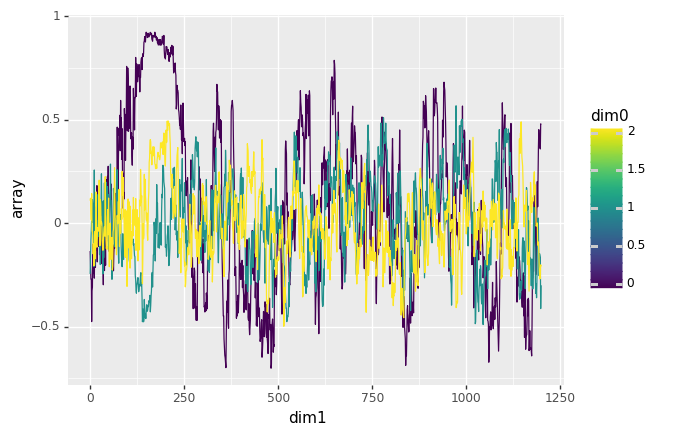

<ggplot: (-9223363242743791998)>

In [52]:
(gg.ggplot(lazytools.array_to_dataframe(np.array(angles)/10), gg.aes(x='dim1', color='dim0', y='array', group='dim0')) +
    gg.geom_line())

This already works way worse. What about less width?

In [54]:
loss_trajs = []
angles = []
for orp in [0.75, 0.9, 0.95]:
    obm = lt.data.OccludedBinaryModel(width=10, occlusion_probability=0.1, occlusion_remainder_probability=orp, occlusion_range=0.2, presamples=10000)
    tmp_upa = clamp.get_upa(input_features=10, latent_features=1, timesteps=5)
    latent_array = obm.values.reshape(1, *obm.values.shape)
    dataset = tmp_upa.dataset(obm.to_array().reshape(1, *obm.to_array().shape),
                         latent_array, timesteps=5)
    loss_traj = []
    angle = []
    epochs = 50
    optimizer = optim.Adam(tmp_upa.parameters(), lr=0.01)
    with tqdm(total=len(dataset)*epochs) as pbar:
        for epoch in range(epochs):
            running_loss = 0
            for i, data in enumerate(dataset):
                optimizer.zero_grad()
                model_output = tmp_upa(data)
                loss = tmp_upa.loss(model_output, data,
                                input_loss=nn.MSELoss(),
                                latent_loss=patches.losses.BilinearLoss())
                loss.backward()
                optimizer.step()
                running_loss += loss
                if i % 50 == 49:
                    loss_traj.append(running_loss.detach().numpy()/50)
                    coder = next(tmp_upa.parameters()).detach().numpy().flatten()
                    angle.append(coder.sum()/np.sqrt((coder**2).sum()))
                    running_loss = 0
                pbar.update(1)
    loss_trajs.append(loss_traj)
    angles.append(angle)

100%|██████████| 62450/62450 [01:43<00:00, 605.16it/s]


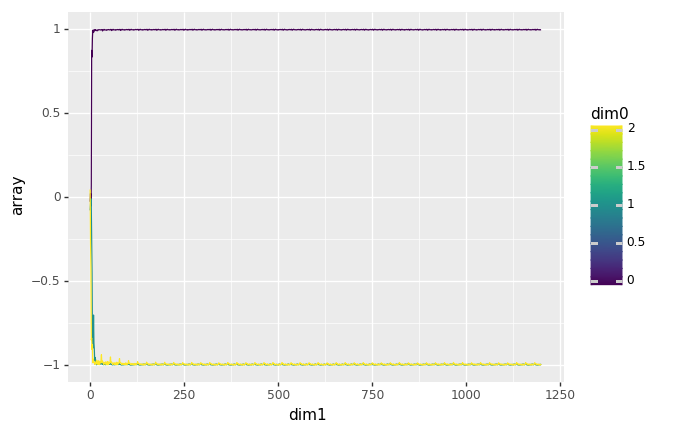

<ggplot: (-9223363242743930729)>

In [56]:
(gg.ggplot(lazytools.array_to_dataframe(np.array(angles)/np.sqrt(10)), gg.aes(x='dim1', color='dim0', y='array', group='dim0')) +
    gg.geom_line())

This works. Still, the investigation indicates that contrastive coding is far more robust to noise in the samples -- this should be investigated from a mathematical perspective.